<a href="https://colab.research.google.com/github/sathsara1/emplyee-retain-period-analyzer/blob/main/randomForestForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install mlcroissant

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.4/565.4 kB 17.1 MB/s eta 0:00:00
  Created wheel for jsonpath-rw: filename=jsonpath_rw-1.4.0-py3-none-any.whl size=15127 sha256=c58334bc0c974c7741dc6318353765e074cd8d0712ef8b7750932edbd6605ea8
  Stored in directory: /root/.cache/pip/wheels/e5/8d/50/ee73263c97069bd6040ff40633d444fefaac7beff73abe81a7
Successfully built jsonpath-rw


In [2]:
import mlcroissant as mlc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
def load_and_preprocess_data():
    croissant_dataset = mlc.Dataset('https://www.kaggle.com/datasets/stealthtechnologies/employee-attrition-dataset/croissant/download')

    record_sets = croissant_dataset.metadata.record_sets
    print(f"Found {len(record_sets)} record sets in the dataset")

    # Use training data
    training_record_set = None
    for record_set in record_sets:
        if 'train' in record_set.name.lower():
            training_record_set = record_set
            break

    if training_record_set is None:
        training_record_set = record_sets[0]

    print(f"Using training data: {training_record_set.name}")

    df = pd.DataFrame(croissant_dataset.records(record_set=training_record_set.uuid))

    df.columns = df.columns.str.replace(r'^[^/]+/', '', regex=True)
    df.columns = df.columns.str.replace(r'\+', ' ', regex=True)

    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    print("\nBasic statistics:")
    print(df.describe())

    return df


In [4]:

def create_retention_target(df):
    df_with_target = df.copy()

    years_at_company = pd.to_numeric(df_with_target['Years at Company'], errors='coerce')
    attrition = df_with_target['Attrition'].astype(str).str.strip().str.lower()

    # Create binary target: 1 if stayed 1+ year, 0 otherwise
    will_stay = np.where((years_at_company >= 1) & (attrition == 'stayed'), 1, 0)

    df_with_target['Will_Stay_1_Year'] = will_stay

    df_with_target['Retention_Probability'] = will_stay.astype(float)

    print(f"\nRetention Target Statistics:")
    print(f"   Will stay 1+ year: {df_with_target['Will_Stay_1_Year'].sum()} employees")
    print(f"   Will leave within 1 year: {(df_with_target['Will_Stay_1_Year'] == 0).sum()} employees")
    print(f"   Retention rate: {df_with_target['Will_Stay_1_Year'].mean():.1%}")

    return df_with_target



In [5]:
def visualize_data(df):
    print("\nEmployee Retention Data Analysis:")

    # Employee Retention Distribution
    retention_counts = df['Will_Stay_1_Year'].value_counts()
    plt.figure(figsize=(6,5))
    plt.pie(retention_counts.values, labels=['Will Leave', 'Will Stay'],
            autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
    plt.title('Employee Retention Distribution')
    plt.show()

    # Job Satisfaction vs Retention
    if 'Job Satisfaction' in df.columns:
        job_sat_retention = df.groupby('Job Satisfaction')['Will_Stay_1_Year'].mean()
        plt.figure(figsize=(8,5))
        plt.bar(range(len(job_sat_retention)), job_sat_retention.values,
                color='skyblue', edgecolor='black')
        plt.title('Retention Rate by Job Satisfaction')
        plt.xlabel('Job Satisfaction Level')
        plt.ylabel('Retention Rate')
        plt.xticks(range(len(job_sat_retention)), job_sat_retention.index)
        plt.grid(True, alpha=0.3)
        plt.show()

    # Years at Company vs Retention
    if 'Years at Company' in df.columns:
        years_retention = df.groupby('Years at Company')['Will_Stay_1_Year'].mean()
        plt.figure(figsize=(8,5))
        plt.plot(years_retention.index, years_retention.values,
                 marker='o', linewidth=2, markersize=6, color='purple')
        plt.title('Retention Rate by Years at Company')
        plt.xlabel('Years at Company')
        plt.ylabel('Retention Rate')
        plt.grid(True, alpha=0.3)
        plt.show()

    # Company Tenure vs Retention
    if 'Company Tenure' in df.columns:
        tenure_retention = df.groupby('Company Tenure')['Will_Stay_1_Year'].mean()
        plt.figure(figsize=(8,5))
        plt.scatter(tenure_retention.index, tenure_retention.values,
                    alpha=0.6, color='orange', s=50)
        plt.title('Retention Rate by Company Tenure (Months)')
        plt.xlabel('Company Tenure (Months)')
        plt.ylabel('Retention Rate')
        plt.grid(True, alpha=0.3)
        plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    correlation_matrix = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()



In [6]:
def preprocess_features(df):

    df_processed = df.copy()

    # Drop non-predictive columns
    columns_to_drop = ['Employee ID', 'Attrition']
    existing_columns_to_drop = [col for col in columns_to_drop if col in df_processed.columns]
    if existing_columns_to_drop:
        df_processed = df_processed.drop(existing_columns_to_drop, axis=1)

    target_cols = ['Will_Stay_1_Year', 'Retention_Probability']
    feature_cols = [col for col in df_processed.columns if col not in target_cols]

    label_encoders = {}
    categorical_columns = df_processed[feature_cols].select_dtypes(include=['object']).columns

    for column in categorical_columns:
        le = LabelEncoder()
        df_processed[column] = le.fit_transform(df_processed[column])
        label_encoders[column] = le

    print(f"Processed dataset shape: {df_processed.shape}")
    return df_processed, label_encoders


In [7]:

def train_retention_model(df):

    target_cols = ['Will_Stay_1_Year', 'Retention_Probability']
    feature_cols = [col for col in df.columns if col not in target_cols]

    X = df[feature_cols]
    y = df['Will_Stay_1_Year']  # Binary target

    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [10, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }

    print("\nPerforming GridSearchCV for Random Forest...")
    print("Parameter grid:")
    for param, values in param_grid.items():
        print(f"   {param}: {values}")

    # Create base Random Forest model
    rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

    # Perform GridSearchCV (optimized for speed)
    grid_search = GridSearchCV(
        estimator=rf_base,
        param_grid=param_grid,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)

    # Get the best model
    rf_model = grid_search.best_estimator_

    print(f"\nGridSearchCV Results:")
    print(f"   Best parameters: {grid_search.best_params_}")
    print(f"   Best cross-validation score: {grid_search.best_score_:.4f}")

    # Make predictions with best model
    y_pred_train = rf_model.predict(X_train_scaled)
    y_pred_test = rf_model.predict(X_test_scaled)

    # Get probabilities
    y_prob_train = rf_model.predict_proba(X_train_scaled)[:, 1]
    y_prob_test = rf_model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    # Model score (accuracy for classification)
    train_score = rf_model.score(X_train_scaled, y_train)
    test_score = rf_model.score(X_test_scaled, y_test)

    print(f"\nMODEL PERFORMANCE:")
    print(f"   Training Score: {train_score:.4f}")
    print(f"   Test Score: {test_score:.4f}")
    print(f"   Training Accuracy: {train_accuracy:.4f}")
    print(f"   Test Accuracy: {test_accuracy:.4f}")
    # Cross-validation
    print("\nPerforming cross-validation...")
    cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    print(f"   Cross-validation AUC scores: {cv_scores}")
    print(f"   Mean CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return rf_model, scaler, X_train, X_test, y_train, y_test, y_pred_test, y_prob_test, grid_search



In [8]:
def analyze_feature_importance(model, feature_names):

    # Get feature importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("Top 10 Most Important Features:")
    print(feature_importance_df.head(10))

    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], color='lightblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Most Important Features for Employee Retention Prediction',
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return feature_importance_df



In [9]:
def evaluate_model_performance(y_test, y_pred, y_prob, model, X_test_scaled):

    # Create evaluation plots
    print("\nModel Performance Evaluation:")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Will Leave', 'Will Stay'])
    plt.yticks([0.5, 1.5], ['Will Leave', 'Will Stay'])
    plt.show()

    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Prediction Probability Distribution
    plt.figure(figsize=(8,5))
    plt.hist(y_prob[y_test == 0], bins=20, alpha=0.7, label='Will Leave', color='red')
    plt.hist(y_prob[y_test == 1], bins=20, alpha=0.7, label='Will Stay', color='green')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Probabilities')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Classification Report Visualization
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics = ['precision', 'recall', 'f1-score']
    classes = ['0', '1']

    x = np.arange(len(classes))
    width = 0.25

    plt.figure(figsize=(8,5))
    for i, metric in enumerate(metrics):
        values = [report[class_name][metric] for class_name in classes]
        plt.bar(x + i*width, values, width, label=metric, alpha=0.8)

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Classification Metrics')
    plt.xticks(x + width, ['Will Leave', 'Will Stay'])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Calculate additional detailed metrics
    mse = mean_squared_error(y_test, y_prob)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_prob)

    # Print detailed metrics
    print(f"\nDETAILED PERFORMANCE METRICS:")
    print(f"   Model Score: {model.score(X_test_scaled, y_test):.4f}")
    print(f"   Accuracy: {accuracy_score(y_test, y_pred):.4f}")


    print(f"\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=['Will Leave', 'Will Stay']))



In [10]:
def predict_employee_retention(model, scaler, feature_names, employee_data):

    if isinstance(employee_data, dict):
        employee_df = pd.DataFrame([employee_data])
    else:
        employee_df = employee_data.copy()

    missing_features = set(feature_names) - set(employee_df.columns)
    if missing_features:
        print(f" Missing features: {missing_features}")
        return None

    employee_features = employee_df[feature_names]

    employee_scaled = scaler.transform(employee_features)

    retention_probability = model.predict_proba(employee_scaled)[0][1]

    print(f"Retention Probability: {retention_probability:.1%}")

    # Interpretation of the prediction
    if retention_probability >= 0.8:
        interpretation = "Very high likelihood of staying 1+ year"
    elif retention_probability >= 0.6:
        interpretation = "High likelihood of staying 1+ year"
    elif retention_probability >= 0.4:
        interpretation = "Moderate likelihood of staying 1+ year"
    else:
        interpretation = "Low likelihood of staying 1+ year"

    print(f"Interpretation: {interpretation}")

    return retention_probability


  -  [Metadata(Employee Attrition Classification Dataset)] Property "http://mlcommons.org/croissant/citeAs" is recommended, but does not exist.
  -  [Metadata(Employee Attrition Classification Dataset)] Property "https://schema.org/version" is recommended, but does not exist.


Found 2 record sets in the dataset
Using training data: train.csv



First 5 rows of the dataset:
  Employee ID  Age     Gender  Years at Company       Job Role  \
0     b'8410'   31    b'Male'                19   b'Education'   
1    b'64756'   59  b'Female'                 4       b'Media'   
2    b'30257'   24  b'Female'                10  b'Healthcare'   
3    b'65791'   36  b'Female'                 7   b'Education'   
4    b'65026'   56    b'Male'                41   b'Education'   

   Monthly Income Work-Life Balance Job Satisfaction Performance Rating  \
0            5390      b'Excellent'        b'Medium'         b'Average'   
1            5534           b'Poor'          b'High'             b'Low'   
2            8159           b'Good'          b'High'             b'Low'   
3            3989           b'Good'          b'High'            b'High'   
4            4821           b'Fair'     b'Very High'         b'Average'   

   Number of Promotions  ...  Number of Dependents  Job Level Company Size  \
0                     2  ...                

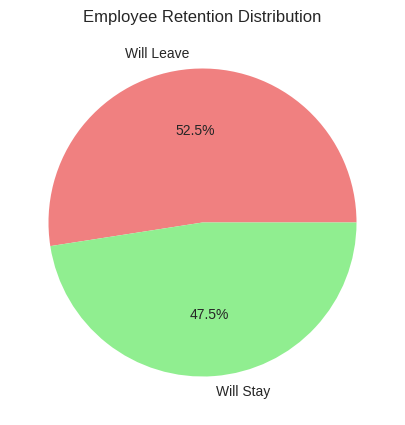

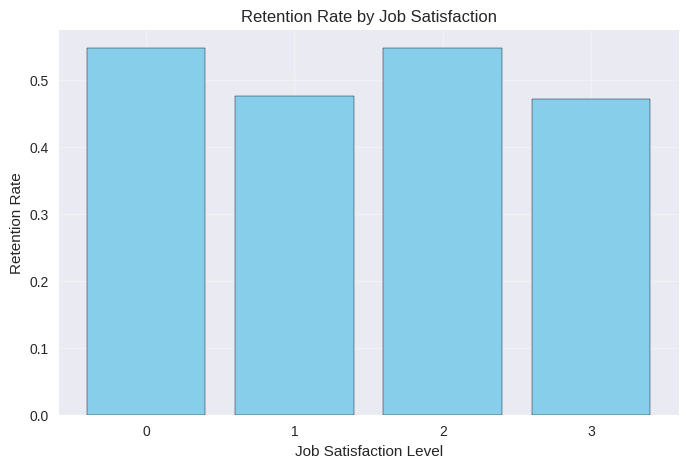

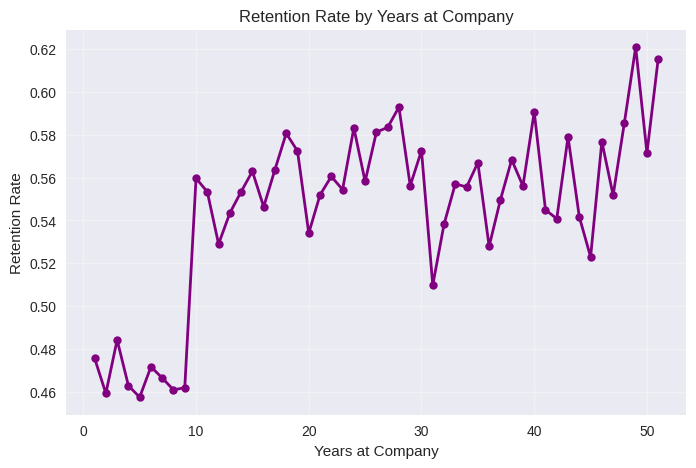

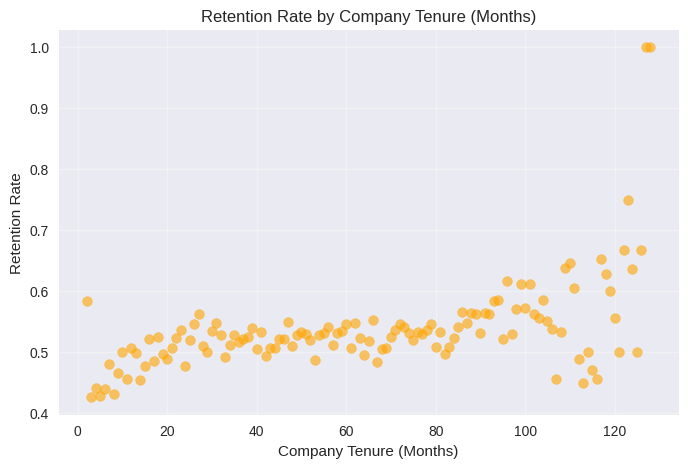

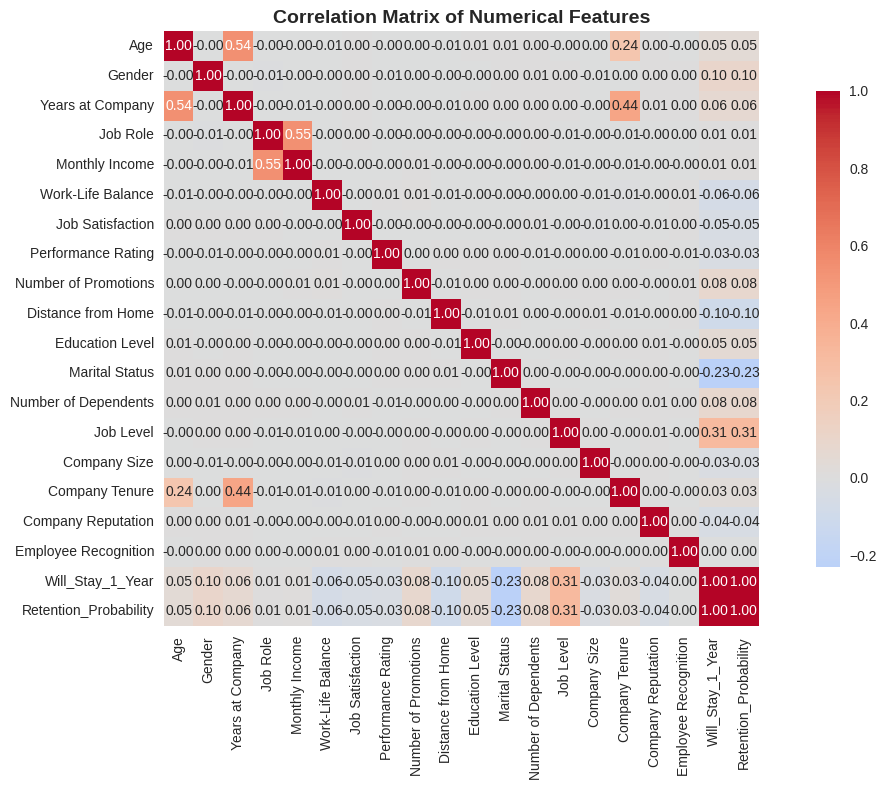

Features shape: (59598, 22)
Target shape: (59598,)
Training set: 47678 samples
Test set: 11920 samples

Performing GridSearchCV for Random Forest...
Parameter grid:
   n_estimators: [50, 100]
   max_depth: [10, 15]
   min_samples_split: [2, 5]
   min_samples_leaf: [1, 2]
   max_features: ['sqrt', 'log2']
Fitting 3 folds for each of 32 candidates, totalling 96 fits

GridSearchCV Results:
   Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
   Best cross-validation score: 0.8056

MODEL PERFORMANCE:
   Training Score: 0.7571
   Test Score: 0.7242
   Training Accuracy: 0.7571
   Test Accuracy: 0.7242

Performing cross-validation...
   Cross-validation AUC scores: [0.81554132 0.79680497 0.80342389 0.80575495 0.80726237]
   Mean CV AUC: 0.8058 (+/- 0.0121)

Best Parameters Found:
   max_depth: 10
   max_features: sqrt
   min_samples_leaf: 2
   min_samples_split: 5
   n_estimators: 100

Cross-Validation Score: 0.8056

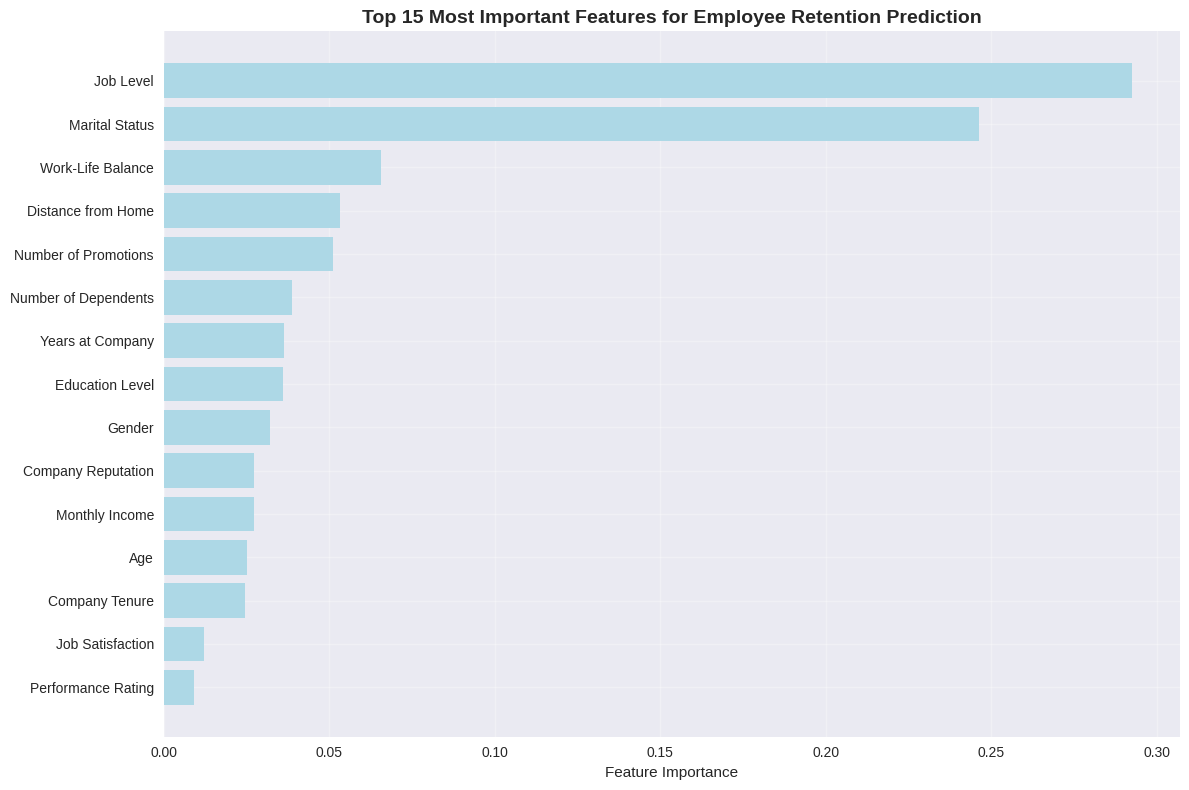


Model Performance Evaluation:


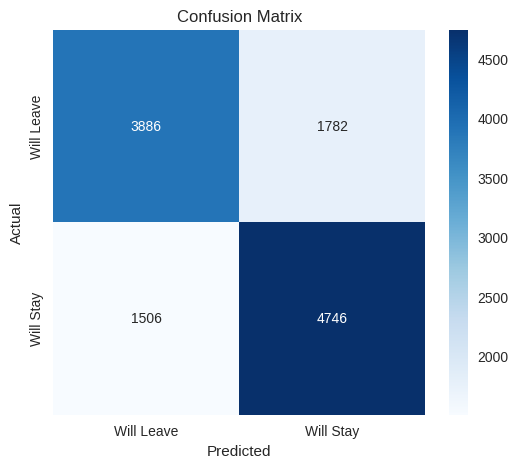

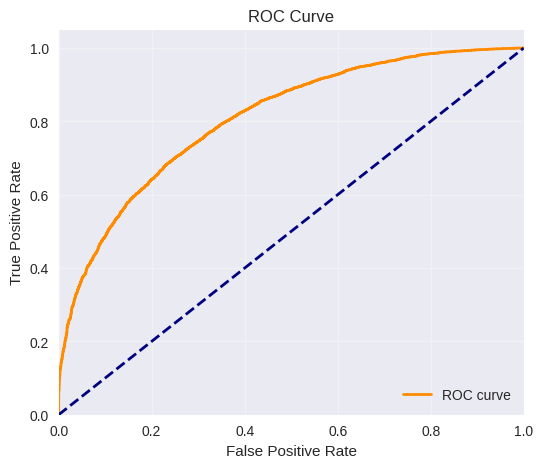

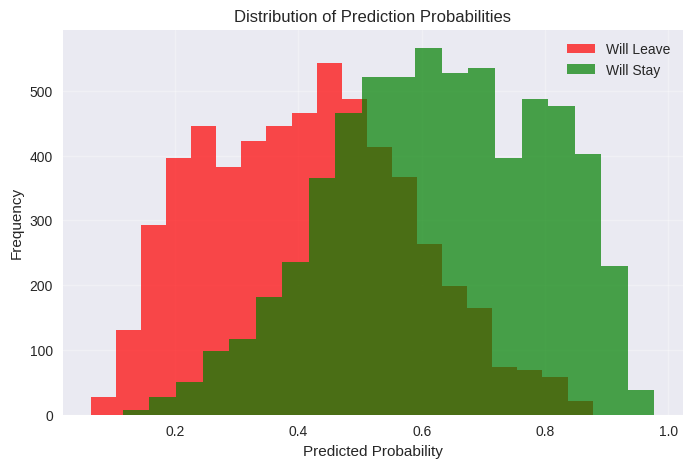

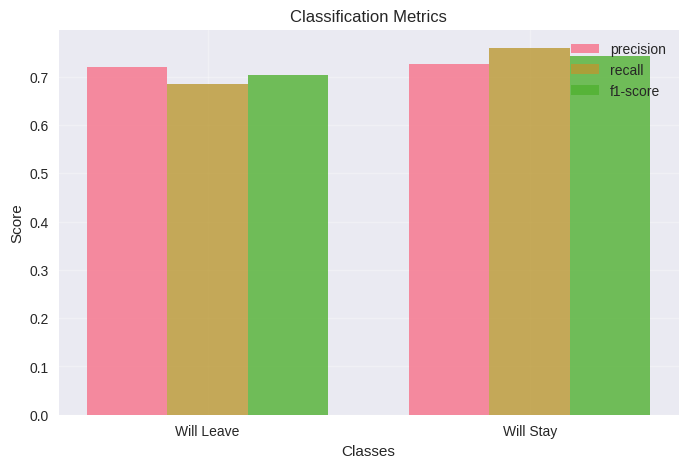


DETAILED PERFORMANCE METRICS:
   Model Score: 0.7242
   Accuracy: 0.7242

Classification report:
              precision    recall  f1-score   support

  Will Leave       0.72      0.69      0.70      5668
   Will Stay       0.73      0.76      0.74      6252

    accuracy                           0.72     11920
   macro avg       0.72      0.72      0.72     11920
weighted avg       0.72      0.72      0.72     11920

Sample employee features:
   Age: 49
   Gender: 0
   Years at Company: 35
   Job Role: 1
   Monthly Income: 8608
   Work-Life Balance: 2
   Job Satisfaction: 1
   Performance Rating: 3
   Number of Promotions: 1
   Overtime: True
   Distance from Home: 27
   Education Level: 0
   Marital Status: 2
   Number of Dependents: 0
   Job Level: 1
   Company Size: 0
   Company Tenure: 52
   Remote Work: True
   Leadership Opportunities: True
   Innovation Opportunities: True
   Company Reputation: 3
   Employee Recognition: 1
Retention Probability: 27.1%
Interpretation: Low li

In [11]:

def main():

    # Load and preprocess data
    df = load_and_preprocess_data()

    # Create retention target
    df_with_target = create_retention_target(df)

    # Preprocess features (clean data)
    df_processed, label_encoders = preprocess_features(df_with_target)

    # Visualize processed data
    visualize_data(df_processed)

    # Train model
    model, scaler, X_train, X_test, y_train, y_test, y_pred, y_prob, grid_search = train_retention_model(df_processed)

    # Show best parameters
    print(f"\nBest Parameters Found:")
    for param, value in grid_search.best_params_.items():
        print(f"   {param}: {value}")

    # Show best score
    print(f"\nCross-Validation Score: {grid_search.best_score_:.4f}")

    # Show top 5 parameter combinations
    results_df = pd.DataFrame(grid_search.cv_results_)
    top_results = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]

    print(f"\nTop 5 Parameter Combinations:")
    for idx, row in top_results.iterrows():
        print(f"\n   Rank {len(top_results) - list(top_results.index).index(idx)}:")
        print(f"   Parameters: {row['params']}")
        print(f"   Mean CV Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']*2:.4f})")


    # Scale test data for evaluation
    X_test_scaled = scaler.transform(X_test)

    # Analyze feature importance
    feature_importance_df = analyze_feature_importance(model, X_train.columns)

    # Evaluate model performance
    evaluate_model_performance(y_test, y_pred, y_prob, model, X_test_scaled)

    # Create a sample employee for prediction
    sample_employee = X_test.iloc[0].to_dict()
    print("Sample employee features:")
    for key, value in sample_employee.items():
        print(f"   {key}: {value}")

    predicted_probability = predict_employee_retention(
        model, scaler, X_train.columns, sample_employee
    )

    print(f"\nActual retention status: {'Will stay 1+ year' if y_test.iloc[0] == 1 else 'Will leave within 1 year'}")
    print(f"Predicted probability: {predicted_probability:.1%}")


    return model, scaler, feature_importance_df

if __name__ == "__main__":
    # Run the main analysis
    try:
        model, scaler, feature_importance = main()
        print("\nModel training completed successfully!")
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
